<h1 style="border-bottom:2px solid black;padding:3px;color:#222">
Import Required Libraries
</h1>

In [1]:
# Ignore warnings
import warnings 
warnings.filterwarnings("ignore")

# Utils
import time

# Libs for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#libs for model
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

<h1 style="border-bottom:2px solid black;padding:3px;color:#222">
Function for Wrangling data [importing - cleaning]
</h1>

In [2]:
# function for wrangling data [importing - cleaning]
def wrangle(file_path):
    
    # Get the data
    df=pd.read_csv(file_path)
    
    # convert Date to datetime object 
    df["Date"]=pd.to_datetime(df["Date"])
    
    # set Date column as index
    df.set_index("Date",inplace=True)
    
    
    # change the name of "Daily minimum temperatures" to make it shorter
    df.rename(columns={"Daily minimum temperatures":"mintemp"},inplace=True)
    
    # fix values of temp column and change its type to float
    df["mintemp"]=df["mintemp"].str.replace("?","").astype(float)
    
    # convert the dataframe to series
    y=df["mintemp"]
    
    # using resample to solve the problem of dates which are not in the data
    y=y.resample("D").sum().fillna(method="ffill")
    
    return y

<h1 style="border-bottom:2px solid black;padding:3px;color:#222">
Exploring Data
</h1>

In [3]:
y=wrangle("daily-minimum-temperatures-in-me.csv")

In [4]:
y.head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Freq: D, Name: mintemp, dtype: float64

In [5]:
y.index

DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '1990-12-22', '1990-12-23', '1990-12-24', '1990-12-25',
               '1990-12-26', '1990-12-27', '1990-12-28', '1990-12-29',
               '1990-12-30', '1990-12-31'],
              dtype='datetime64[ns]', name='Date', length=3652, freq='D')

In [6]:
y.isna().sum()

0

In [7]:
y.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 3652 entries, 1981-01-01 to 1990-12-31
Freq: D
Series name: mintemp
Non-Null Count  Dtype  
--------------  -----  
3652 non-null   float64
dtypes: float64(1)
memory usage: 57.1 KB


<p style="border-bottom:8px solid #333;padding:5px;">

</p>

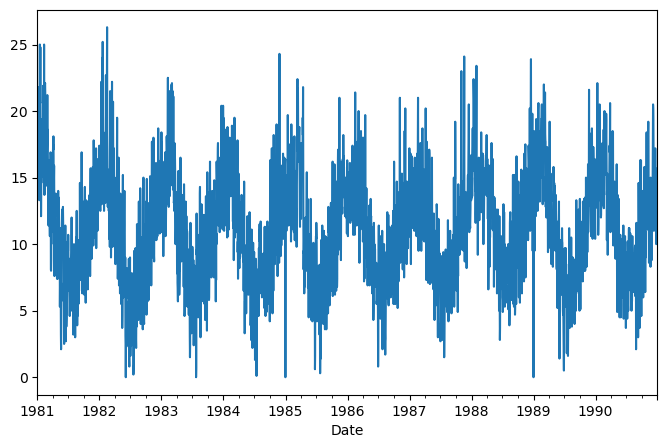

In [8]:
fig,ax=plt.subplots(figsize=(8,5))
y.plot(ax=ax)
plt.show()

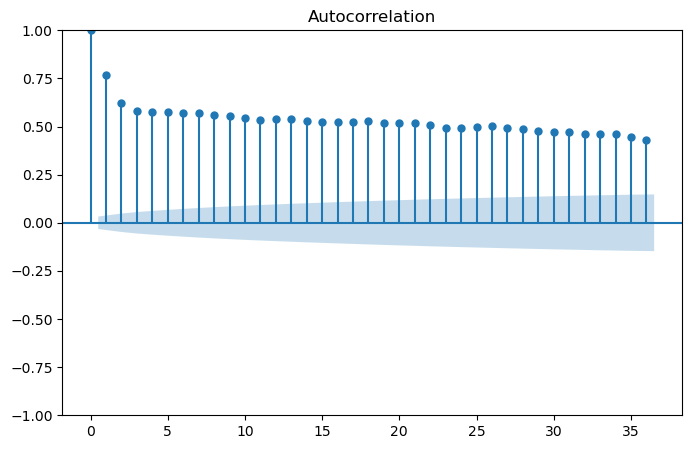

In [9]:
fig,ax=plt.subplots(figsize=(8,5))
plot_acf(y,ax=ax)
plt.show()

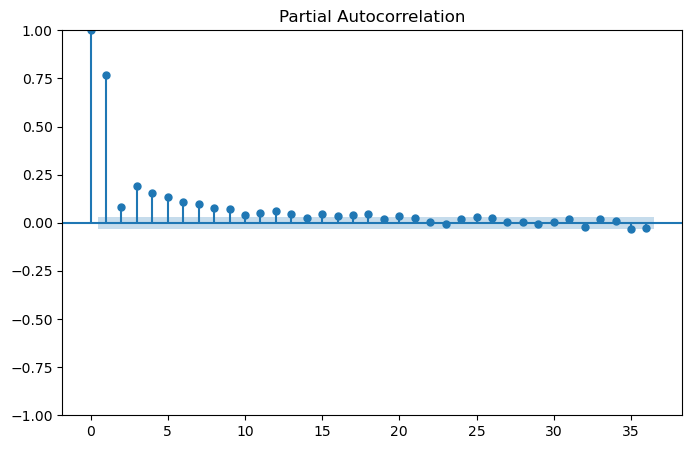

In [10]:
fig,ax=plt.subplots(figsize=(8,5))
plot_pacf(y,ax=ax)
plt.show()

<h1 style="border-bottom:2px solid black;padding:3px;color:#222">
Split Data
</h1>

In [11]:
y_cutoff=int(len(y)*.95)
y_train=y.iloc[ : y_cutoff]
y_test=y.iloc[y_cutoff : ]

In [12]:
len(y_test)

183

In [13]:
y_test.isna().sum()

0

<h1 style="border-bottom:2px solid black;padding:3px;color:#222">
Baseline model
</h1>

In [14]:
y_mean=y_train.mean()
y_pred_baseline=[y_mean]*len(y_train)
print("y_mean : ",round(y_mean,2))
print("mae for y_baseline : ",round(mean_absolute_error(y_train[:],y_pred_baseline),2))

y_mean :  11.2
mae for y_baseline :  3.31


<p style="border-bottom:2px solid black;padding:5px;color:#fff;background-color:#222;border-radius:5px;height:100px;line-height:100px;font-size:30px;text-align:left">
1st model
</p>

<h1 style="border-bottom:2px solid black;padding:3px;color:#222">
    Model training
</h1>

In [15]:
model=AutoReg(y_train,lags=9).fit()

In [16]:
y_pred_train=model.predict().dropna()

In [17]:
print("mae for training : ",round(mean_absolute_error(y_train[9:],y_pred_train),2))

mae for training :  1.92


<h1 style="border-bottom:2px solid black;padding:3px;color:#222">
    Residuals exploring
</h1>

In [18]:
y_train_resid=model.resid

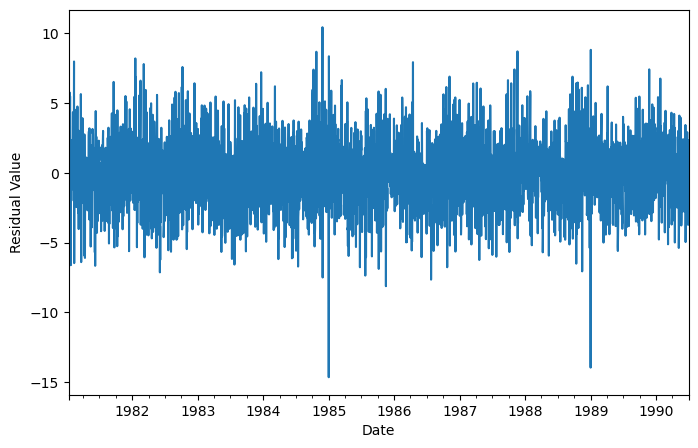

In [19]:
fig,ax=plt.subplots(figsize=(8,5))
y_train_resid.plot(ax=ax,ylabel="Residual Value");

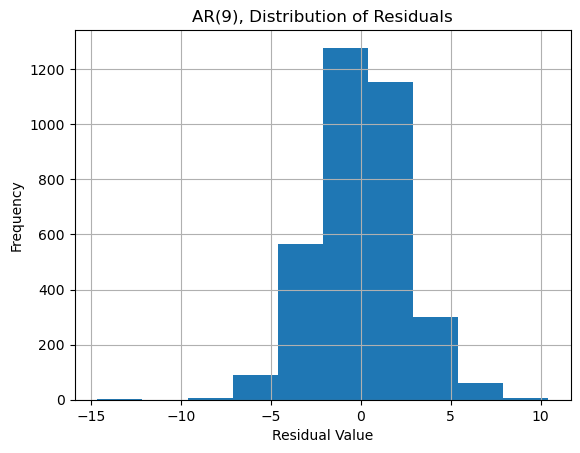

In [20]:
y_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("AR(9), Distribution of Residuals");

From the histogram above 👆, we see that : Residuals have bell curve distribution

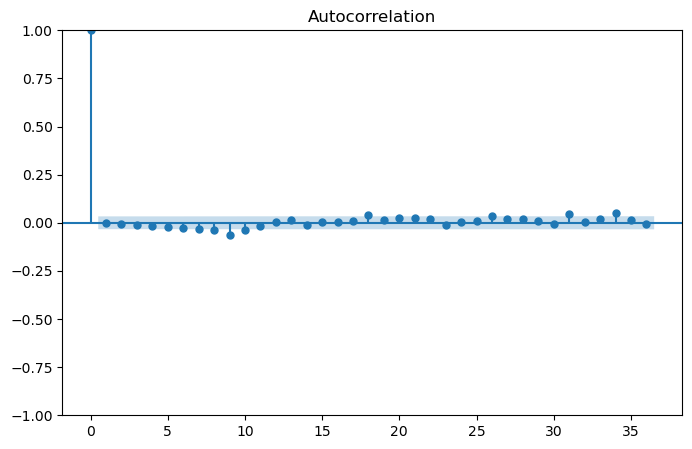

In [21]:
fig,ax=plt.subplots(figsize=(8,5))
plot_acf(y_train_resid,ax=ax)
plt.show()

<h1 style="border-bottom:2px solid black;padding:3px;color:#222">
    Model evaluation
</h1>

In [22]:
y_pred_test=model.predict(y_test.index.min(),y_test.index.max())
print("mae for testing : ",round(mean_absolute_error(y_test,y_pred_test),2))

mae for testing :  2.44


<h1 style="border-bottom:2px solid black;padding:3px;color:#222">
    Model evaluation using Walk Forward Validation (WFV)
</h1>

In [27]:
# clone training data
history=y_train.copy()
# make empty series
y_pred_wfv=pd.Series()
for i in range(len(y_test)):
    # fit the model with the next prediction
    model=AutoReg(history,lags=9).fit()
    # forecast one prediction of test set (one by one) 
    next_pred=model.forecast()
    # append the prediction to y_pred_wfv
    y_pred_wfv=y_pred_wfv.append(next_pred)
    # append the next observation from y_test to history
    history=history.append(y_test[next_pred.index])
    

In [28]:
y_pred_wfv

1990-07-02     7.337540
1990-07-03     7.367328
1990-07-04     7.596623
1990-07-05     7.504348
1990-07-06     8.643557
                ...    
1990-12-27    14.149504
1990-12-28    13.419219
1990-12-29    13.264935
1990-12-30    13.143314
1990-12-31    14.490620
Freq: D, Length: 183, dtype: float64

In [29]:
print("mae for testing using wfv : ",round(mean_absolute_error(y_test,y_pred_wfv),2))

mae for testing using wfv :  1.82


We see that using wfv is much more efficient

<h1 style="border-bottom:2px solid black;padding:3px;color:#222">
    Communication of Results
</h1>

In [41]:
print("Y = ",round(model.params[0],2),end="")
for i in range(1,len(model.params)):
    print(" + (",round(model.params[i],2),f"*x{i+1} )",end="")

Y =  0.99 + ( 0.6 *x2 ) + ( -0.08 *x3 ) + ( 0.07 *x4 ) + ( 0.05 *x5 ) + ( 0.06 *x6 ) + ( 0.05 *x7 ) + ( 0.05 *x8 ) + ( 0.03 *x9 ) + ( 0.07 *x10 )

In [43]:
df_pred_test=pd.DataFrame(
{"y_test":y_test,"y_pred_wfv":y_pred_wfv},index=y_test.index
)
fig=px.line(df_pred_test,labels={"value":"minTemp"})
fig.show()

<p style="border-bottom:2px solid black;padding:5px;color:#fff;background-color:#222;border-radius:5px;height:100px;line-height:100px;font-size:30px;text-align:left">
2nd model
</p>